Data on berkley 59 on The Unified Cluster Catalogue (UCC) https://ucc.ar/_clusters/berkeley59/

In [ ]:
!pip install numpy astropy matplotlib photutils astroquery # Check for libraries

# Photometric Analysis of Berkeley59 from GAIA DR3 using motion analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.visualization import AsymmetricPercentileInterval
from astropy.stats import sigma_clipped_stats, SigmaClip
import pandas as pd
from astroquery.gaia import Gaia
from scipy.stats import sigmaclip
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import warnings
import os

In [ ]:
# Berkeley 59 parameters
cluster_ra = 0.57
cluster_dec = 67.441
search_radius = 0.15  # degrees

query = f"""
SELECT TOP 8000
    source_id, ra, dec, pmra, pmdec, pmra_error, pmdec_error,
    parallax, parallax_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
    ruwe, phot_g_mean_flux_over_error, phot_bp_mean_flux_over_error, phot_rp_mean_flux_over_error,
    astrometric_excess_noise, visibility_periods_used
FROM gaiadr3.gaia_source
WHERE
    CONTAINS(POINT('ICRS', ra, dec),
             CIRCLE('ICRS', {cluster_ra}, {cluster_dec}, {search_radius})) = 1
    AND pmra IS NOT NULL
    AND pmdec IS NOT NULL
    AND phot_g_mean_mag IS NOT NULL
    AND phot_bp_mean_mag IS NOT NULL
    AND phot_rp_mean_mag IS NOT NULL
    AND ruwe < 1.4
    AND visibility_periods_used > 8
    AND phot_g_mean_flux_over_error > 5
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job_async(query)
gaia_data = job.get_results()
gaia_df = gaia_data.to_pandas()

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
print(gaia_data)

    source_id               ra         ... visibility_periods_used
                           deg         ...                        
------------------ ------------------- ... -----------------------
528582522771464448  0.9135653872486211 ...                      27
528594342521399168 0.44526463316853215 ...                      26
528592796334452352  0.5796376455157765 ...                      27
528569294272172928  0.5566017828073003 ...                      26
528595373313539200  0.6498036669373408 ...                      28
528593311729266560  0.5520168527209357 ...                      27
528594308161653760  0.4663316364479348 ...                      27
528580353809305344  0.8731597669987092 ...                      27
528595338953802880  0.7080369237442803 ...                      28
               ...                 ... ...                     ...
528581766855637248  0.9501087433866653 ...                      15
528593380446173952  0.6149874565522117 ...                    

In [ ]:
pm_ra_mean = np.mean(gaia_df['pmra'])
pm_dec_mean = np.mean(gaia_df['pmdec'])
pm_ra_std = np.std(gaia_df['pmra'])
pm_dec_std = np.std(gaia_df['pmdec'])

In [ ]:
cluster_mask = np.ones(len(gaia_df), dtype=bool)
n_iterations = 30
sigma_threshold = 2.0

for iteration in range(n_iterations):
    pm_ra_cluster = gaia_df.loc[cluster_mask, 'pmra']
    pm_dec_cluster = gaia_df.loc[cluster_mask, 'pmdec']

    pm_ra_mean = np.mean(pm_ra_cluster)
    pm_dec_mean = np.mean(pm_dec_cluster)
    pm_ra_std = np.std(pm_ra_cluster)
    pm_dec_std = np.std(pm_dec_cluster)

    pm_distance = np.sqrt(
        ((gaia_df['pmra'] - pm_ra_mean) / pm_ra_std)**2 +
        ((gaia_df['pmdec'] - pm_dec_mean) / pm_dec_std)**2
    )

    new_cluster_mask = pm_distance < sigma_threshold
    n_changed = np.sum(cluster_mask != new_cluster_mask)
    cluster_mask = new_cluster_mask

    print(f"  Iteration {iteration+1}: {cluster_mask.sum()} members (changed={n_changed})")

    if n_changed < 5:
        print(f"  └─ Converged after {iteration+1} iterations")
        break

parallax_valid = (
    (gaia_df['parallax'].notna()) &
    (gaia_df['parallax_error'].notna()) &
    (gaia_df['parallax_error'] > 0)
)

if parallax_valid.sum() > 10:
    parallax_snr = np.abs(gaia_df['parallax']) / gaia_df['parallax_error']

    cluster_parallax_median = np.median(gaia_df.loc[cluster_mask & parallax_valid, 'parallax'])
    cluster_parallax_std = np.std(gaia_df.loc[cluster_mask & parallax_valid, 'parallax'])

    parallax_filter = (
        ~parallax_valid |
        (parallax_snr < 3) |
        (np.abs(gaia_df['parallax'] - cluster_parallax_median) < 3 * cluster_parallax_std)
    )

    n_before = cluster_mask.sum()
    cluster_mask = cluster_mask & parallax_filter
    n_removed = n_before - cluster_mask.sum()

  Iteration 1: 1959 members (changed=103)
  Iteration 2: 1705 members (changed=254)
  Iteration 3: 1428 members (changed=277)
  Iteration 4: 1193 members (changed=235)
  Iteration 5: 1009 members (changed=184)
  Iteration 6: 844 members (changed=165)
  Iteration 7: 715 members (changed=129)
  Iteration 8: 605 members (changed=110)
  Iteration 9: 517 members (changed=88)
  Iteration 10: 450 members (changed=67)
  Iteration 11: 384 members (changed=66)
  Iteration 12: 330 members (changed=54)
  Iteration 13: 286 members (changed=44)
  Iteration 14: 247 members (changed=39)
  Iteration 15: 219 members (changed=28)
  Iteration 16: 194 members (changed=25)
  Iteration 17: 175 members (changed=19)
  Iteration 18: 161 members (changed=14)
  Iteration 19: 149 members (changed=12)
  Iteration 20: 143 members (changed=6)
  Iteration 21: 138 members (changed=5)
  Iteration 22: 135 members (changed=3)
  └─ Converged after 22 iterations


In [ ]:
gaia_df['is_member'] = cluster_mask
gaia_cluster = gaia_df[cluster_mask].copy()
gaia_field = gaia_df[~cluster_mask].copy()

print(f"\n Final membership:")
print(f"Cluster members: {len(gaia_cluster)} ({100*len(gaia_cluster)/len(gaia_df):.1f}%)")
print(f"Field stars: {len(gaia_field)} ({100*len(gaia_field)/len(gaia_df):.1f}%)")
print(f"\nCluster proper motion:")
print(f"  <pmRA>  = {np.mean(gaia_cluster['pmra']):.3f} ± {np.std(gaia_cluster['pmra']):.3f} mas/yr")
print(f"  <pmDec> = {np.mean(gaia_cluster['pmdec']):.3f} ± {np.std(gaia_cluster['pmdec']):.3f} mas/yr")



 Final membership:
Cluster members: 134 (6.5%)
Field stars: 1928 (93.5%)

Cluster proper motion:
  <pmRA>  = -1.635 ± 0.112 mas/yr
  <pmDec> = -1.909 ± 0.108 mas/yr


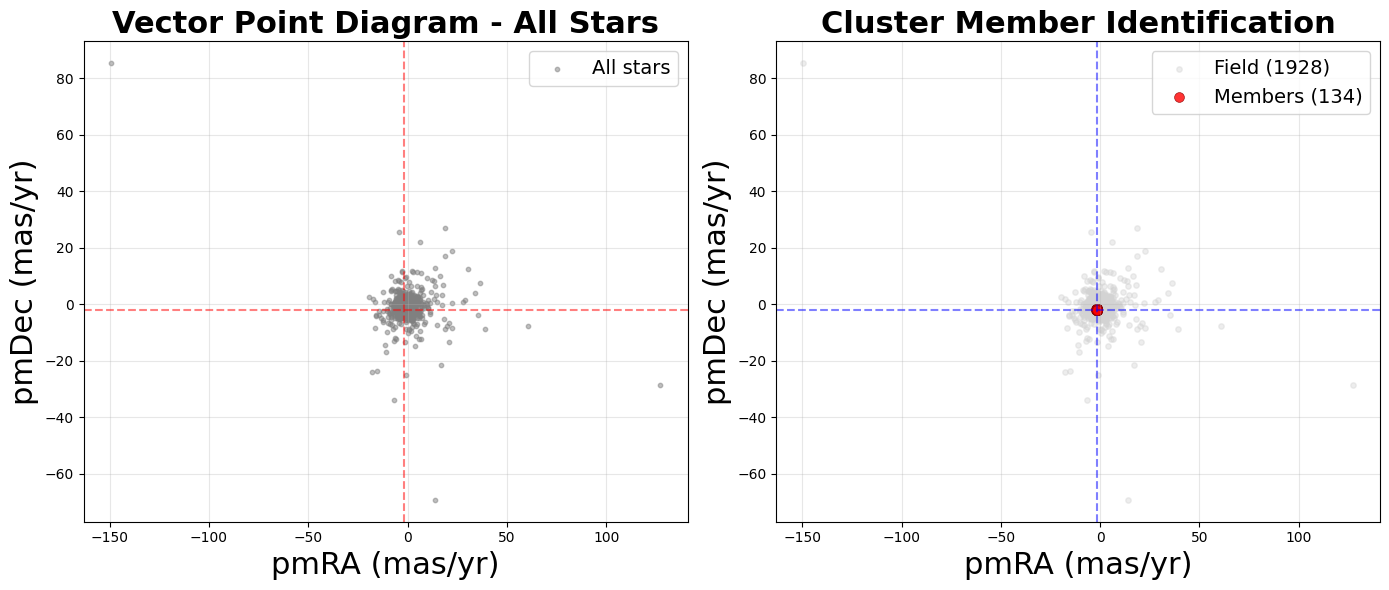

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
ax1.scatter(gaia_df['pmra'], gaia_df['pmdec'], s=10, alpha=0.5, c='gray', label='All stars')
ax1.axhline(pm_dec_mean, color='red', linestyle='--', alpha=0.5)
ax1.axvline(pm_ra_mean, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('pmRA (mas/yr)', fontsize=22)
ax1.set_ylabel('pmDec (mas/yr)', fontsize=22)
ax1.set_title('Vector Point Diagram - All Stars', fontsize=22, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=14)


ax2 = axes[1]
ax2.scatter(gaia_field['pmra'], gaia_field['pmdec'],
           s=15, alpha=0.4, c='lightgray', label=f'Field ({len(gaia_field)})')
ax2.scatter(gaia_cluster['pmra'], gaia_cluster['pmdec'],
           s=50, alpha=0.8, c='red', edgecolors='darkred', linewidth=0.5,
           label=f'Members ({len(gaia_cluster)})')
ax2.axhline(np.mean(gaia_cluster['pmdec']), color='blue', linestyle='--', alpha=0.5)
ax2.axvline(np.mean(gaia_cluster['pmra']), color='blue', linestyle='--', alpha=0.5)
ax2.set_xlabel('pmRA (mas/yr)', fontsize=22)
ax2.set_ylabel('pmDec (mas/yr)', fontsize=22)
ax2.set_title('Cluster Member Identification', fontsize=22, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=14)



plt.tight_layout()
plt.show()

In [ ]:
# hdul_g = fits.open("Berk_g.wcs.proc.fits")
# hdul_r = fits.open("Berk_r.wcs.proc.fits")
# hdul_i = fits.open("Berk_i.wcs.proc.fits")

# image_r = hdul_r[0].data
# image_g = hdul_g[0].data
# image_i = hdul_i[0].data

In [ ]:
#for drive
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/CV resources/[Undergoing project] PH556 Astrophysics Course Project/data/Berkeley 59'
os.listdir(folder_path)

file_g = os.path.join(folder_path, 'Berk_g.wcs.proc.fits')
file_r = os.path.join(folder_path, 'Berk_r.wcs.proc.fits')
file_i = os.path.join(folder_path, 'Berk_i.wcs.proc.fits')

hdul_g = fits.open(file_g)
hdul_r = fits.open(file_r)
hdul_i = fits.open(file_i)

image_r = hdul_r[0].data
image_g = hdul_g[0].data
image_i = hdul_i[0].data

berkeley_csv = os.path.join(folder_path, 'berkeley.csv')

Mounted at /content/drive


In [ ]:
hdul_g[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1608                                                  
NAXIS2  =                 1104                                                  
DATE-OBS= '2025-10-17T15:18:54' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   100.00000000000000 /Exposure time in seconds                        
EXPOSURE=   100.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.010000228881836 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.0000000000000000 /Pixel Width in microns (after binning)          
YPIXSZ  =   9.0000000000000000 /Pixel Height in microns (after binning)         
XBINNING=                   

In [ ]:
wcs_i = WCS(hdul_i[0].header)
wcs_r = WCS(hdul_r[0].header)
wcs_g = WCS(hdul_g[0].header)

coords = np.column_stack([gaia_df['ra'].values, gaia_df['dec'].values])

x_pix_r, y_pix_r = wcs_r.wcs_world2pix(coords, 0).T
x_pix_g, y_pix_g = wcs_g.wcs_world2pix(coords, 0).T
x_pix_i, y_pix_i = wcs_i.wcs_world2pix(coords, 0).T

gaia_df['x_pix_g'] = x_pix_g
gaia_df['y_pix_g'] = y_pix_g
gaia_df['x_pix_r'] = x_pix_r
gaia_df['y_pix_r'] = y_pix_r
gaia_df['x_pix_i'] = x_pix_i
gaia_df['y_pix_i'] = y_pix_i

In [ ]:
h, w = image_i.shape
margin = 10

in_bounds = (
    (x_pix_i > margin) & (x_pix_i < w - margin) &
    (y_pix_i > margin) & (y_pix_i < h - margin) &
    (x_pix_r > margin) & (x_pix_r < w - margin) &
    (y_pix_r > margin) & (y_pix_r < h - margin) &
    (x_pix_g > margin) & (x_pix_g < w - margin) &
    (y_pix_g > margin) & (y_pix_g < h - margin)
)

gaia_df['in_bounds'] = in_bounds
n_in_bounds = in_bounds.sum()
n_members_in_bounds = (gaia_df['is_member'] & in_bounds).sum()

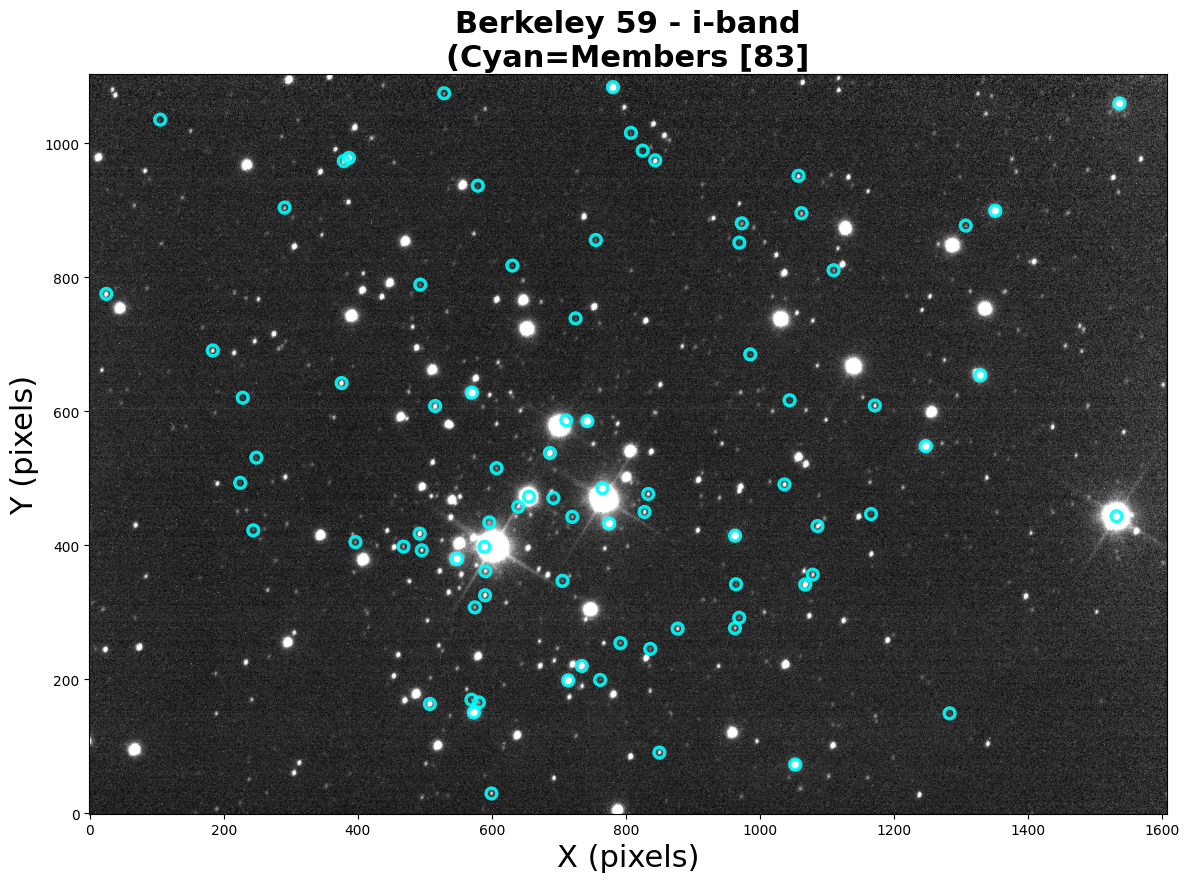

In [ ]:
# Display image
interval = AsymmetricPercentileInterval(1, 99)
vmin, vmax = interval.get_limits(image_i)

fig, ax = plt.subplots(figsize=(12, 12),)
ax.imshow(image_i, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
member_in_bounds = gaia_df['in_bounds'] & gaia_df['is_member']
for idx in gaia_df[member_in_bounds].index:
    x, y = gaia_df.loc[idx, 'x_pix_i'], gaia_df.loc[idx, 'y_pix_i']
    circle = plt.Circle((x, y), radius=8, edgecolor='cyan',
                       alpha=0.9, facecolor='none', linewidth=2.5)
    ax.add_artist(circle)

ax.set_title(f'Berkeley 59 - i-band\n(Cyan=Members [{n_members_in_bounds}]',
            fontsize=22, fontweight='bold')
ax.set_xlabel('X (pixels)', fontsize=22)
ax.set_ylabel('Y (pixels)', fontsize=22)
ax.set_facecolor('#A7D4FF')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_fixed_photometry(image, positions, aperture_radius, annulus_radii):
    # Number of stars
    n_stars = len(positions)

    # Arrays to store results:
    flux_bkgsub = np.zeros(n_stars)
    bkg_values = np.zeros(n_stars)
    apertures = CircularAperture(positions, r=aperture_radius)
    annuli = CircularAnnulus(positions, r_in=annulus_radii[0], r_out=annulus_radii[1])
    annulus_masks = annuli.to_mask(method='center')

    for i in range(n_stars):
        mask = annulus_masks[i]
        annulus_data = mask.multiply(image)
        if annulus_data is None:
            bkg_values[i] = np.nan
            flux_bkgsub[i] = np.nan
            continue
        annulus_data_1d = annulus_data[mask.data > 0]
        if len(annulus_data_1d) > 5:
            sigclip = SigmaClip(sigma=3.0, maxiters=5)
            clipped_data = sigclip(annulus_data_1d, masked=False)
            bkg_median = np.median(clipped_data[~np.isnan(clipped_data)])
        else:
            bkg_median = np.median(annulus_data_1d)
        bkg_values[i] = bkg_median
    phot_table = aperture_photometry(image, apertures, method='exact')
    total_bkg = bkg_values * apertures.area
    flux_bkgsub = phot_table['aperture_sum'] - total_bkg
    return flux_bkgsub, bkg_values

# Get image statistics
mean_r, median_r, std_r = sigma_clipped_stats(image_r, sigma=3.0)
mean_g, median_g, std_g = sigma_clipped_stats(image_g, sigma=3.0)
mean_i, median_i, std_i = sigma_clipped_stats(image_i, sigma=3.0)

In [ ]:
# Filter for cluster members that are also within the image bounds
members_in_bounds_df = gaia_df[gaia_df['is_member'] & gaia_df['in_bounds']].copy()

if len(members_in_bounds_df) == 0:
    print("No cluster members found within image bounds with valid photometry.")
else:
    positions_r = np.column_stack([members_in_bounds_df['x_pix_r'].values, members_in_bounds_df['y_pix_r'].values])
    positions_g = np.column_stack([members_in_bounds_df['x_pix_g'].values, members_in_bounds_df['y_pix_g'].values])
    positions_i = np.column_stack([members_in_bounds_df['x_pix_i'].values, members_in_bounds_df['y_pix_i'].values])

    flux_g, bkg_g = calculate_fixed_photometry(image_g, positions_g, aperture_radius=10, annulus_radii=(12,14))
    flux_r, bkg_r = calculate_fixed_photometry(image_r, positions_r, aperture_radius=10, annulus_radii=(12,14))
    flux_i, bkg_i = calculate_fixed_photometry(image_i, positions_i, aperture_radius=10, annulus_radii=(12,14))

    # Add flux and background columns to the members_in_bounds_df
    members_in_bounds_df['flux_g'] = flux_g
    members_in_bounds_df['flux_r'] = flux_r
    members_in_bounds_df['flux_i'] = flux_i
    members_in_bounds_df['bkg_g'] = bkg_g
    members_in_bounds_df['bkg_r'] = bkg_r
    members_in_bounds_df['bkg_i'] = bkg_i

    # Create a valid_phot mask based on positive fluxes
    valid_phot_mask = (members_in_bounds_df['flux_r'] > 0) & (members_in_bounds_df['flux_g'] > 0) & (members_in_bounds_df['flux_i'] > 0)

    # Add a column indicating valid photometry BEFORE filtering
    members_in_bounds_df['valid_phot'] = valid_phot_mask

    # Filter the DataFrame to keep only stars with valid photometry
    in_bounds_df = members_in_bounds_df[valid_phot_mask].copy()


    print(f"Number of cluster members with valid photometry: {len(in_bounds_df)}")

Number of cluster members with valid photometry: 55


In [ ]:
in_bounds_df['mag_g_inst'] = np.where(in_bounds_df['valid_phot'],
-2.5 * np.log10(in_bounds_df['flux_g']), np.nan)
in_bounds_df['mag_r_inst'] = np.where(in_bounds_df['valid_phot'], -2.5 * np.log10(in_bounds_df['flux_r']), np.nan)
in_bounds_df['mag_i_inst'] = np.where(in_bounds_df['valid_phot'], -2.5 * np.log10(in_bounds_df['flux_i']), np.nan)

In [ ]:
# Airmass from header
AIRMASS = 1.2967281749896205

# Standard extinction coefficients for SDSS filters (mag/airmass)
k_g = 0.18
k_r = 0.10
k_i = 0.06

# Create calibration sample
calibration_df = in_bounds_df[valid_phot_mask].copy()
print(f"Calibration sample: {len(calibration_df)} stars")

if len(calibration_df) > 10:
    # Extract Gaia magnitudes
    gaia_G = calibration_df['phot_g_mean_mag'].values
    gaia_BP = calibration_df['phot_bp_mean_mag'].values
    gaia_RP = calibration_df['phot_rp_mean_mag'].values

    # Extract instrumental magnitudes from the calibration sample
    mag_g_inst = calibration_df['mag_g_inst'].values
    mag_r_inst = calibration_df['mag_r_inst'].values
    mag_i_inst = calibration_df['mag_i_inst'].values


    # Valid data mask
    valid_cal = (
        ~np.isnan(gaia_G) & ~np.isnan(gaia_BP) & ~np.isnan(gaia_RP) &
        ~np.isnan(mag_g_inst) & ~np.isnan(mag_r_inst) & ~np.isnan(mag_i_inst) &
        np.isfinite(gaia_G) & np.isfinite(gaia_BP) & np.isfinite(gaia_RP) &
        np.isfinite(mag_g_inst) & np.isfinite(mag_r_inst) & np.isfinite(mag_i_inst)
    )

    # Apply mask
    gaia_G = gaia_G[valid_cal]
    gaia_BP = gaia_BP[valid_cal]
    gaia_RP = gaia_RP[valid_cal]
    mag_g_inst = mag_g_inst[valid_cal]
    mag_r_inst = mag_r_inst[valid_cal]
    mag_i_inst = mag_i_inst[valid_cal]

    # Calculate Gaia color
    bp_rp = gaia_BP - gaia_RP

    gaia_g_sdss = gaia_G - (0.13518 - 0.46245*bp_rp - 0.25171*bp_rp**2 + 0.021349*bp_rp**3)

    gaia_r_sdss = gaia_G - (-0.12879 + 0.24662*bp_rp - 0.027464*bp_rp**2 - 0.049465*bp_rp**3)

    gaia_i_sdss = gaia_G - (-0.29676 + 0.64728*bp_rp - 0.10141*bp_rp**2)

    mag_g_inst_corrected = mag_g_inst - k_g * AIRMASS
    mag_r_inst_corrected = mag_r_inst - k_r * AIRMASS
    mag_i_inst_corrected = mag_i_inst - k_i * AIRMASS

    # Calculate zero points using extinction-corrected instrumental magnitudes
    zp_g_arr = gaia_g_sdss - mag_g_inst_corrected
    zp_r_arr = gaia_r_sdss - mag_r_inst_corrected
    zp_i_arr = gaia_i_sdss - mag_i_inst_corrected

    # More aggressive sigma clipping for g-band
    zp_g_clipped, _, _ = sigmaclip(zp_g_arr, low=2.5, high=2.5)
    zp_r_clipped, _, _ = sigmaclip(zp_r_arr, low=3, high=3)
    zp_i_clipped, _, _ = sigmaclip(zp_i_arr, low=3, high=3)

    # Final zero points
    zp_g = np.median(zp_g_clipped)
    zp_r = np.median(zp_r_clipped)
    zp_i = np.median(zp_i_clipped)

    # Calculate scatter
    zp_g_std = np.std(zp_g_clipped)
    zp_r_std = np.std(zp_r_clipped)
    zp_i_std = np.std(zp_i_clipped)

    from scipy.stats import median_abs_deviation
    zp_g_mad = median_abs_deviation(zp_g_clipped)
    zp_r_mad = median_abs_deviation(zp_r_clipped)
    zp_i_mad = median_abs_deviation(zp_i_clipped)

    fig, axes = plt.subplots(1, 3, figsize=(18, 12))

    # Top row: Calibration quality (with extinction correction)
    axes[0].scatter(gaia_g_sdss, mag_g_inst_corrected + zp_g, alpha=0.6, s=30,
                     c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[0].plot([gaia_g_sdss.min(), gaia_g_sdss.max()],
                   [gaia_g_sdss.min(), gaia_g_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[0].set_xlabel('Gaia g (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[0].set_ylabel('Instrumental g + ZP [mag]', fontsize=22, fontweight='bold')
    axes[0].set_title(f'g-band (ZP={zp_g:.3f}±{zp_g_std:.3f})\nExtinction corrected: -{k_g*AIRMASS:.3f} mag',
                       fontweight='bold', fontsize=16)
    axes[0].grid(True, alpha=0.3)
    legend1 = axes[0].legend(fontsize=14)

    axes[1].scatter(gaia_r_sdss, mag_r_inst_corrected + zp_r, alpha=0.6, s=30,
                     c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[1].plot([gaia_r_sdss.min(), gaia_r_sdss.max()],
                   [gaia_r_sdss.min(), gaia_r_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[1].set_xlabel('Gaia r (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[1].set_ylabel('Instrumental r + ZP [mag]', fontsize=22, fontweight='bold')
    axes[1].set_title(f'r-band (ZP={zp_r:.3f}±{zp_r_std:.3f})\nExtinction corrected: -{k_r*AIRMASS:.3f} mag',
                       fontweight='bold', fontsize=16)
    axes[1].grid(True, alpha=0.3)
    legend2 = axes[1].legend(fontsize=14)

    axes[2].scatter(gaia_i_sdss, mag_i_inst_corrected + zp_i, alpha=0.6, s=30,
                     c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[2].plot([gaia_i_sdss.min(), gaia_i_sdss.max()],
                   [gaia_i_sdss.min(), gaia_i_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[2].set_xlabel('Gaia i (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[2].set_ylabel('Instrumental i + ZP [mag]', fontsize=22, fontweight='bold')
    axes[2].set_title(f'i-band (ZP={zp_i:.3f}±{zp_i_std:.3f})\nExtinction corrected: -{k_i*AIRMASS:.3f} mag',
                       fontweight='bold', fontsize=16)
    axes[2].grid(True, alpha=0.3)
    legend3 = axes[2].legend(fontsize=14)

# First apply extinction correction to all instrumental magnitudes
in_bounds_df['mag_g_inst_corrected'] = in_bounds_df['mag_g_inst'] - k_g * AIRMASS
in_bounds_df['mag_r_inst_corrected'] = in_bounds_df['mag_r_inst'] - k_r * AIRMASS
in_bounds_df['mag_i_inst_corrected'] = in_bounds_df['mag_i_inst'] - k_i * AIRMASS

# Then apply zero points to get calibrated magnitudes
in_bounds_df['mag_g_cal'] = in_bounds_df['mag_g_inst_corrected'] + zp_g
in_bounds_df['mag_r_cal'] = in_bounds_df['mag_r_inst_corrected'] + zp_r
in_bounds_df['mag_i_cal'] = in_bounds_df['mag_i_inst_corrected'] + zp_i

# Calculate calibrated colors
in_bounds_df['color_g_r'] = in_bounds_df['mag_g_cal'] - in_bounds_df['mag_r_cal']
in_bounds_df['color_r_i'] = in_bounds_df['mag_r_cal'] - in_bounds_df['mag_i_cal']
in_bounds_df['color_g_i'] = in_bounds_df['mag_g_cal'] - in_bounds_df['mag_i_cal']

# Add color cuts
in_bounds_df = in_bounds_df[(in_bounds_df['color_r_i'] >= 0.5) & (in_bounds_df['color_g_r'] >= 0.5) & (in_bounds_df['mag_r_cal'] <= 19.5) & (in_bounds_df['color_g_r'] <= 3.5) & (in_bounds_df['color_r_i'] <= 5)]

print(f"\nCalibrated {len(in_bounds_df)} stars with extinction correction")
print(f"Effective zero points (ZP - k*X):")
print(f"  g: {zp_g:.3f} - {k_g*AIRMASS:.3f} = {zp_g - k_g*AIRMASS:.3f}")
print(f"  r: {zp_r:.3f} - {k_r*AIRMASS:.3f} = {zp_r - k_r*AIRMASS:.3f}")
print(f"  i: {zp_i:.3f} - {k_i*AIRMASS:.3f} = {zp_i - k_i*AIRMASS:.3f}")

Calibration sample: 55 stars

Calibrated 42 stars (no extinction correction applied)
Effective zero points:
  g: 25.621
  r: 25.085
  i: 23.727


/tmp/ipython-input-1366331012.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  calibration_df = in_bounds_df[valid_phot_mask].copy()


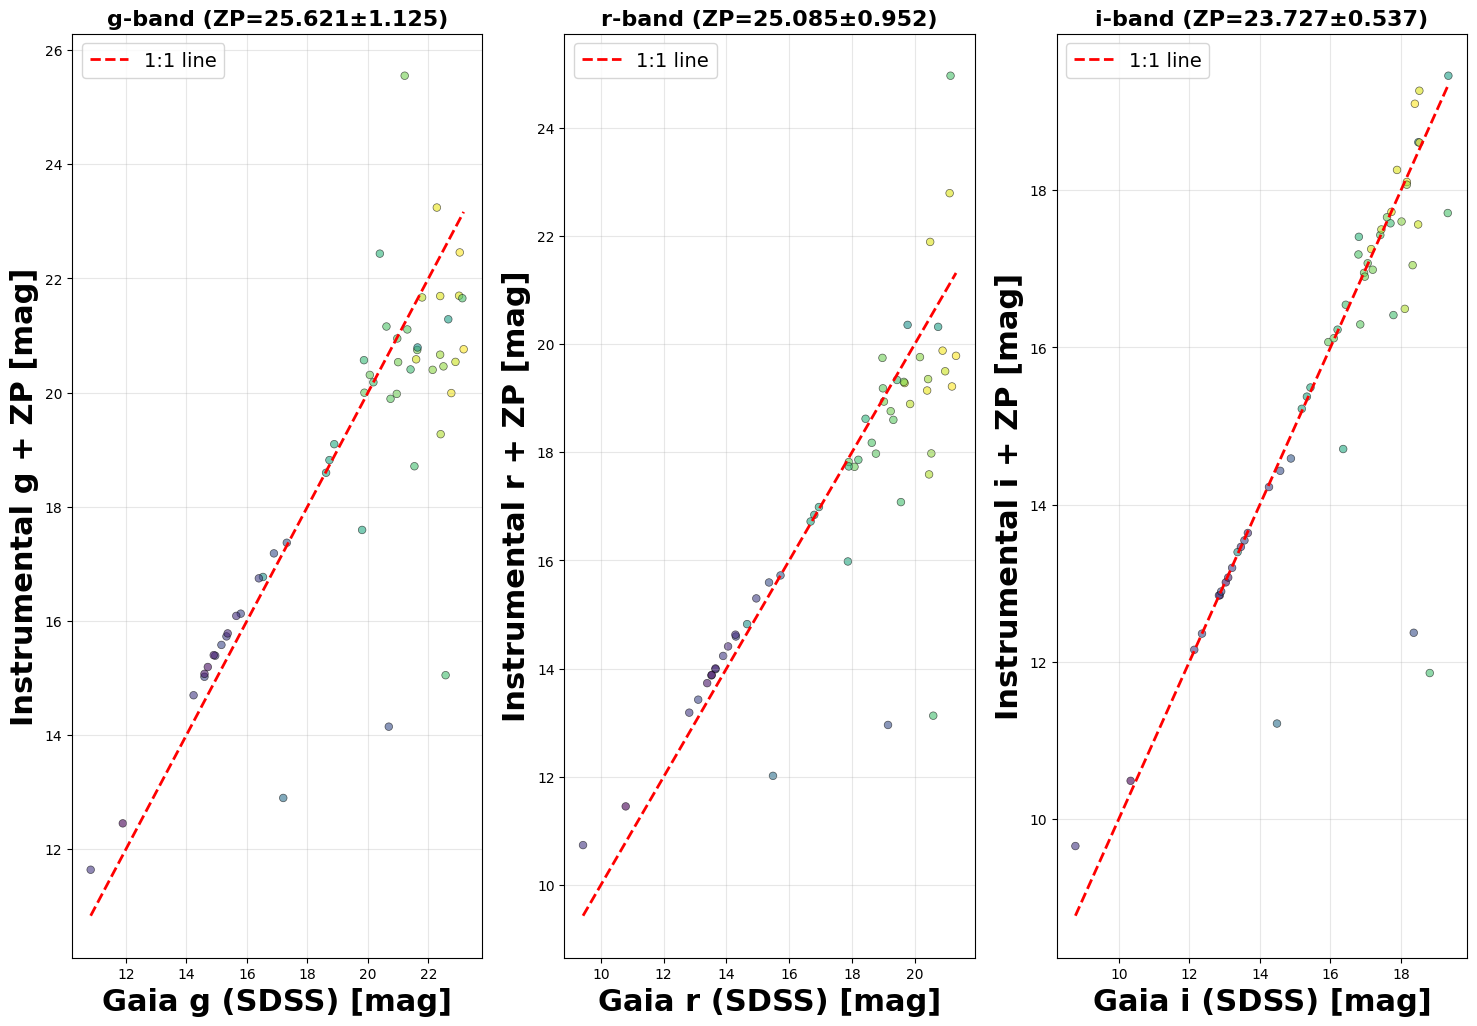

In [ ]:
# Create calibration sample
calibration_df = in_bounds_df[valid_phot_mask].copy()
print(f"Calibration sample: {len(calibration_df)} stars")

if len(calibration_df) > 10:
    # Extract Gaia magnitudes
    gaia_G = calibration_df['phot_g_mean_mag'].values
    gaia_BP = calibration_df['phot_bp_mean_mag'].values
    gaia_RP = calibration_df['phot_rp_mean_mag'].values

    # Extract instrumental magnitudes from the calibration sample
    mag_g_inst = calibration_df['mag_g_inst'].values
    mag_r_inst = calibration_df['mag_r_inst'].values
    mag_i_inst = calibration_df['mag_i_inst'].values

    # Valid data mask
    valid_cal = (
        ~np.isnan(gaia_G) & ~np.isnan(gaia_BP) & ~np.isnan(gaia_RP) &
        ~np.isnan(mag_g_inst) & ~np.isnan(mag_r_inst) & ~np.isnan(mag_i_inst) &
        np.isfinite(gaia_G) & np.isfinite(gaia_BP) & np.isfinite(gaia_RP) &
        np.isfinite(mag_g_inst) & np.isfinite(mag_r_inst) & np.isfinite(mag_i_inst)
    )

    # Apply mask
    gaia_G = gaia_G[valid_cal]
    gaia_BP = gaia_BP[valid_cal]
    gaia_RP = gaia_RP[valid_cal]
    mag_g_inst = mag_g_inst[valid_cal]
    mag_r_inst = mag_r_inst[valid_cal]
    mag_i_inst = mag_i_inst[valid_cal]

    # Calculate Gaia color
    bp_rp = gaia_BP - gaia_RP

    # Transform Gaia magnitudes to SDSS equivalents
    gaia_g_sdss = gaia_G - (0.13518 - 0.46245*bp_rp - 0.25171*bp_rp**2 + 0.021349*bp_rp**3)
    gaia_r_sdss = gaia_G - (-0.12879 + 0.24662*bp_rp - 0.027464*bp_rp**2 - 0.049465*bp_rp**3)
    gaia_i_sdss = gaia_G - (-0.29676 + 0.64728*bp_rp - 0.10141*bp_rp**2)

    # Calculate zero points directly (no extinction correction)
    zp_g_arr = gaia_g_sdss - mag_g_inst
    zp_r_arr = gaia_r_sdss - mag_r_inst
    zp_i_arr = gaia_i_sdss - mag_i_inst

    # Sigma clipping
    from scipy.stats import sigmaclip, median_abs_deviation
    zp_g_clipped, _, _ = sigmaclip(zp_g_arr, low=2.5, high=2.5)
    zp_r_clipped, _, _ = sigmaclip(zp_r_arr, low=3, high=3)
    zp_i_clipped, _, _ = sigmaclip(zp_i_arr, low=3, high=3)

    # Final zero points
    zp_g = np.median(zp_g_clipped)
    zp_r = np.median(zp_r_clipped)
    zp_i = np.median(zp_i_clipped)

    # Scatter (standard deviation and MAD)
    zp_g_std = np.std(zp_g_clipped)
    zp_r_std = np.std(zp_r_clipped)
    zp_i_std = np.std(zp_i_clipped)

    zp_g_mad = median_abs_deviation(zp_g_clipped)
    zp_r_mad = median_abs_deviation(zp_r_clipped)
    zp_i_mad = median_abs_deviation(zp_i_clipped)

    # Plot calibration quality (no extinction correction)
    fig, axes = plt.subplots(1, 3, figsize=(18, 12))

    axes[0].scatter(gaia_g_sdss, mag_g_inst + zp_g, alpha=0.6, s=30,
                    c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[0].plot([gaia_g_sdss.min(), gaia_g_sdss.max()],
                 [gaia_g_sdss.min(), gaia_g_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[0].set_xlabel('Gaia g (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[0].set_ylabel('Instrumental g + ZP [mag]', fontsize=22, fontweight='bold')
    axes[0].set_title(f'g-band (ZP={zp_g:.3f}±{zp_g_std:.3f})',
                      fontweight='bold', fontsize=16)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=14)

    axes[1].scatter(gaia_r_sdss, mag_r_inst + zp_r, alpha=0.6, s=30,
                    c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[1].plot([gaia_r_sdss.min(), gaia_r_sdss.max()],
                 [gaia_r_sdss.min(), gaia_r_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[1].set_xlabel('Gaia r (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[1].set_ylabel('Instrumental r + ZP [mag]', fontsize=22, fontweight='bold')
    axes[1].set_title(f'r-band (ZP={zp_r:.3f}±{zp_r_std:.3f})',
                      fontweight='bold', fontsize=16)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=14)

    axes[2].scatter(gaia_i_sdss, mag_i_inst + zp_i, alpha=0.6, s=30,
                    c=bp_rp, cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[2].plot([gaia_i_sdss.min(), gaia_i_sdss.max()],
                 [gaia_i_sdss.min(), gaia_i_sdss.max()], 'r--', lw=2, label='1:1 line')
    axes[2].set_xlabel('Gaia i (SDSS) [mag]', fontsize=22, fontweight='bold')
    axes[2].set_ylabel('Instrumental i + ZP [mag]', fontsize=22, fontweight='bold')
    axes[2].set_title(f'i-band (ZP={zp_i:.3f}±{zp_i_std:.3f})',
                      fontweight='bold', fontsize=16)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(fontsize=14)

# Apply zero points directly to get calibrated magnitudes (no extinction correction)
in_bounds_df['mag_g_cal'] = in_bounds_df['mag_g_inst'] + zp_g
in_bounds_df['mag_r_cal'] = in_bounds_df['mag_r_inst'] + zp_r
in_bounds_df['mag_i_cal'] = in_bounds_df['mag_i_inst'] + zp_i

# Calculate calibrated colors
in_bounds_df['color_g_r'] = in_bounds_df['mag_g_cal'] - in_bounds_df['mag_r_cal']
in_bounds_df['color_r_i'] = in_bounds_df['mag_r_cal'] - in_bounds_df['mag_i_cal']
in_bounds_df['color_g_i'] = in_bounds_df['mag_g_cal'] - in_bounds_df['mag_i_cal']

# Apply color cuts
in_bounds_df = in_bounds_df[
    (in_bounds_df['color_r_i'] >= 0.5) &
    (in_bounds_df['color_g_r'] >= 0.5) &
    (in_bounds_df['mag_r_cal'] <= 19.5) &
    (in_bounds_df['color_g_r'] <= 3.5) &
    (in_bounds_df['color_r_i'] <= 5)
]

print(f"\nCalibrated {len(in_bounds_df)} stars (no extinction correction applied)")
print("Effective zero points:")
print(f"  g: {zp_g:.3f}")
print(f"  r: {zp_r:.3f}")
print(f"  i: {zp_i:.3f}")


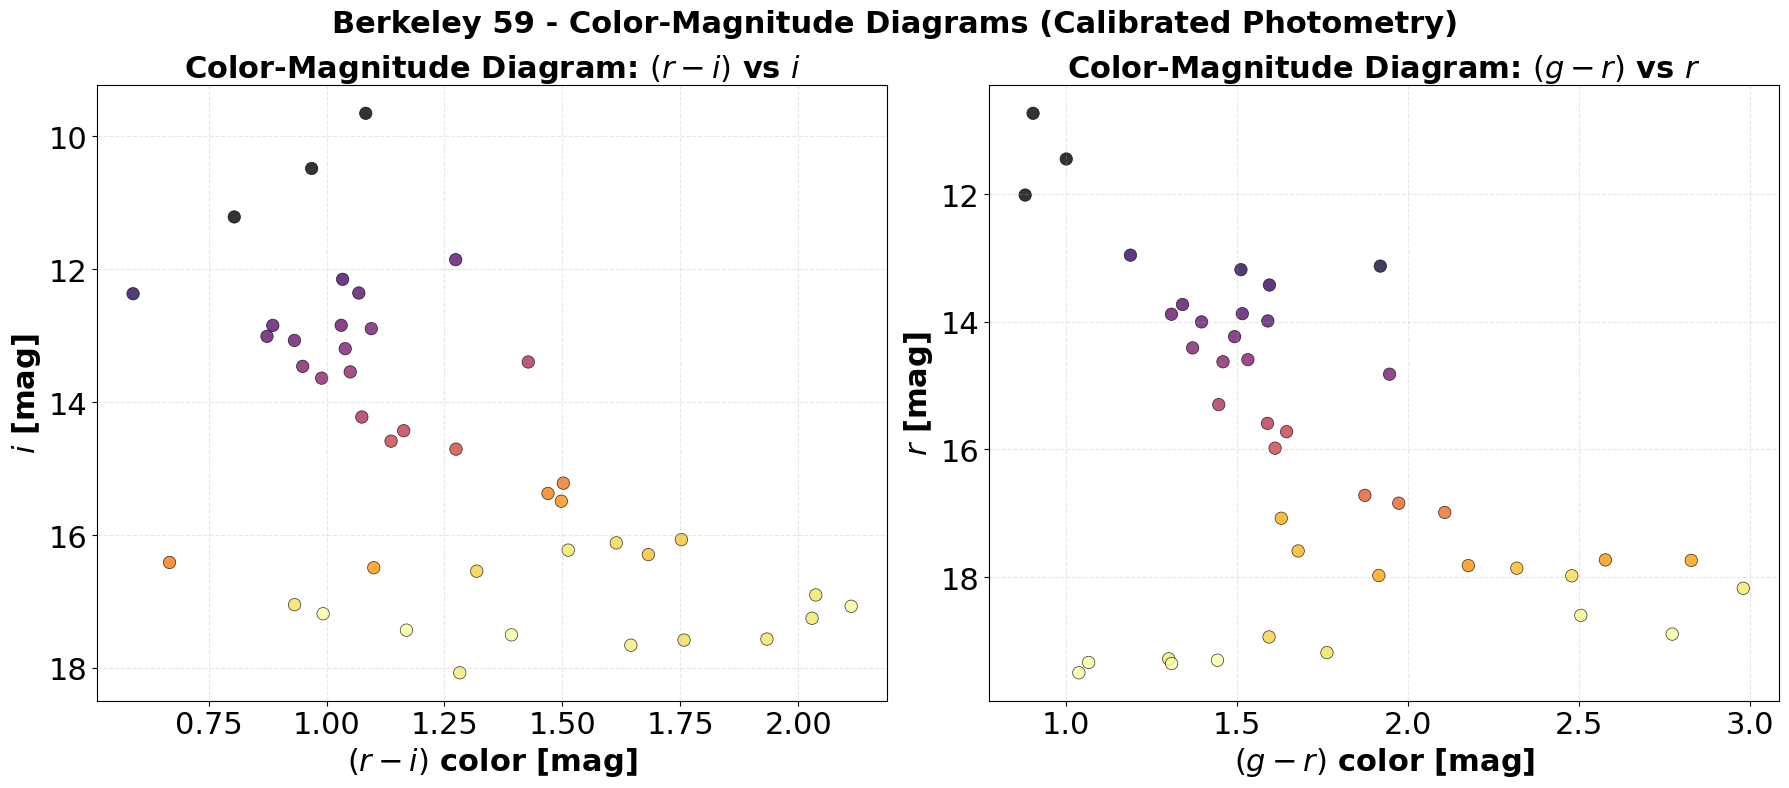

In [ ]:
# Filter for cluster members with valid photometry
members_df = in_bounds_df[in_bounds_df['is_member'] & in_bounds_df['valid_phot']].copy()


# Create figure with two CMDs
fig = plt.figure(figsize=(18, 8),)

# Left panel: (r-i) vs i CMD
ax1 = fig.add_subplot(121)
if len(members_df) > 0:
    scatter1 = ax1.scatter(members_df['color_r_i'], members_df['mag_i_cal'],
                          c=members_df['mag_g_cal'], cmap='inferno', s=80,
                          alpha=0.8, edgecolors='black', linewidth=0.5,
                          vmin=members_df['mag_g_cal'].quantile(0.05),
                          vmax=members_df['mag_g_cal'].quantile(0.95))
    ax1.invert_yaxis()
    ax1.set_xlabel('$(r - i)$ color [mag]', fontsize=22, fontweight='bold')
    ax1.set_ylabel('$i$ [mag]', fontsize=22, fontweight='bold')
    ax1.set_title('Color-Magnitude Diagram: $(r-i)$ vs $i$', fontsize=22, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.tick_params(labelsize=22)



# Right panel: (g-r) vs r CMD
ax2 = fig.add_subplot(122)
if len(members_df) > 0:
    scatter2 = ax2.scatter(members_df['color_g_r'], members_df['mag_r_cal'],
                          c=members_df['mag_i_cal'], cmap='inferno', s=80,
                          alpha=0.8, edgecolors='black', linewidth=0.5,
                          vmin=members_df['mag_i_cal'].quantile(0.05),
                          vmax=members_df['mag_i_cal'].quantile(0.95))
    ax2.invert_yaxis()
    ax2.set_xlabel('$(g - r)$ color [mag]', fontsize=22, fontweight='bold')
    ax2.set_ylabel('$r$ [mag]', fontsize=22, fontweight='bold')
    ax2.set_title('Color-Magnitude Diagram: $(g-r)$ vs $r$', fontsize=22, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.tick_params(labelsize=22)



# Overall title
plt.suptitle('Berkeley 59 - Color-Magnitude Diagrams (Calibrated Photometry)',
            fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1147283830.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno', len(selected_ages))


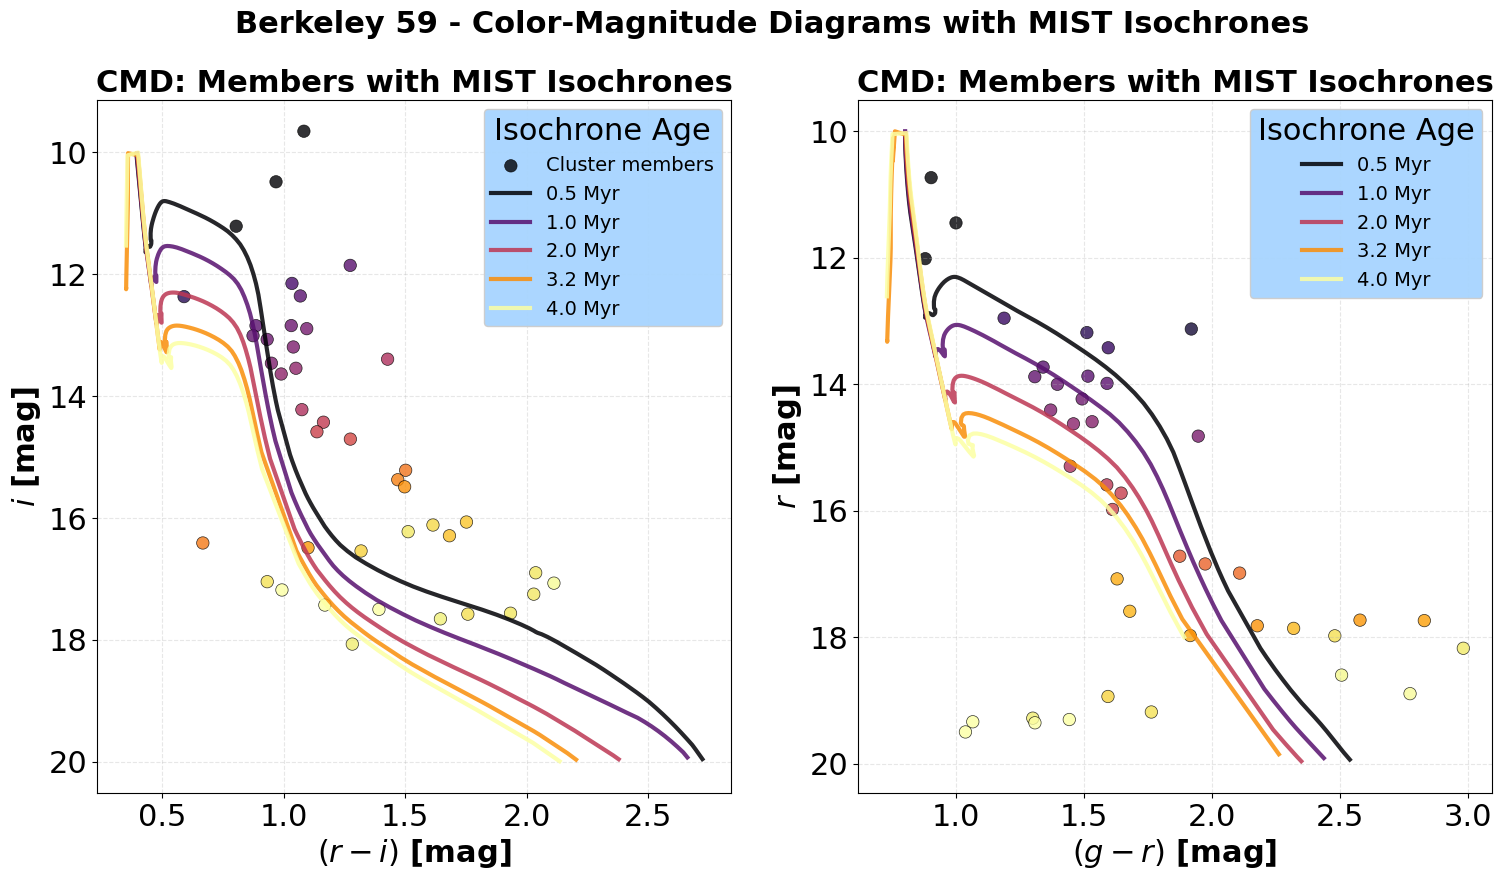

In [ ]:
filename = 'MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd'

columns = ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff',
           'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'SDSS_u', 'SDSS_g', 'SDSS_r',
           'SDSS_i', 'SDSS_z', 'phase']

df = pd.read_csv(filename, sep=r'\s+', names=columns, skiprows=13, comment='#')

# Berkeley 59 parameters from literature
distance_pc = 998.7823428158692
distance_modulus = 5.0 * np.log10(distance_pc / 10.0)
R_V = 3.1
EBV = 1.3
A_g = 3.303*EBV
A_r = 2.285*EBV
A_i = 1.698*EBV

df['SDSS_g_obs'] = df['SDSS_g'] + distance_modulus + A_g
df['SDSS_r_obs'] = df['SDSS_r'] + distance_modulus + A_r
df['SDSS_i_obs'] = df['SDSS_i'] + distance_modulus + A_i

# Calculate after reddening
df['g_minus_r_obs'] = df['SDSS_g_obs'] - df['SDSS_r_obs']
df['r_minus_i_obs'] = df['SDSS_r_obs'] - df['SDSS_i_obs']

# Calculate age in Myr
df['age_Myr'] = 10**(df['log10_isochrone_age_yr'] - 6)
unique_ages = sorted(df['log10_isochrone_age_yr'].unique())
target_ages_Myr = [0.5, 1.0, 2.0, 3.0, 4.0]
target_ages_log = [np.log10(age * 1e6) for age in target_ages_Myr]

selected_ages = []
for target_log in target_ages_log:
    closest_age = min(unique_ages, key=lambda x: abs(x - target_log))
    if closest_age not in selected_ages:
        selected_ages.append(closest_age)

import matplotlib.cm as cm # Import cm

cmap = cm.get_cmap('inferno', len(selected_ages))
age_colors = [cmap(i) for i in range(len(selected_ages))]
members_df = in_bounds_df[in_bounds_df['is_member'] & in_bounds_df['valid_phot']].copy()

fig = plt.figure(figsize=(18, 9),)
# (r-i) vs i
ax1 = fig.add_subplot(121)
if len(members_df) > 0:
    scatter5 = ax1.scatter(members_df['color_r_i'], members_df['mag_i_cal'],
                          c=members_df['mag_g_cal'], cmap='inferno', s=80,
                          alpha=0.8, edgecolors='black', linewidth=0.5,
                          vmin=members_df['mag_g_cal'].quantile(0.05),
                          vmax=members_df['mag_g_cal'].quantile(0.95),
                          zorder=2, label='Cluster members')

    ax1.invert_yaxis()
    ax1.set_xlabel('$(r - i)$ [mag]', fontsize=22, fontweight='bold')
    ax1.set_ylabel('$i$ [mag]', fontsize=22, fontweight='bold')
    ax1.set_title('CMD: Members with MIST Isochrones', fontsize=22, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.tick_params(labelsize=22)
    for idx, log_age in enumerate(selected_ages):
        iso_data = df[df['log10_isochrone_age_yr'] == log_age].copy()
        # Filter isochrone data to relevant magnitude range
        iso_data = iso_data[(iso_data['SDSS_i_obs'] > 10) & (iso_data['SDSS_i_obs'] < 20)].copy()
        age_Myr = 10**(log_age - 6)
        ax1.plot(iso_data['r_minus_i_obs'], iso_data['SDSS_i_obs'],
                color=age_colors[idx], linewidth=3.0, alpha=0.85,
                label=f'{age_Myr:.1f} Myr', zorder=3)
    ax1.legend(loc='upper right', fontsize=14, framealpha=0.95,
              title='Isochrone Age', title_fontsize=22).get_frame().set_facecolor("#A7D4FF")

# (g-r) vs r
ax2 = fig.add_subplot(122)
if len(members_df) > 0:
    scatter2 = ax2.scatter(members_df['color_g_r'], members_df['mag_r_cal'],
                          c=members_df['mag_i_cal'], cmap='inferno', s=80,
                          alpha=0.8, edgecolors='black', linewidth=0.5,
                          vmin=members_df['mag_i_cal'].quantile(0.05),
                          vmax=members_df['mag_i_cal'].quantile(0.95))
    ax2.invert_yaxis()
    ax2.set_xlabel('$(g - r)$ [mag]', fontsize=22, fontweight='bold')
    ax2.set_ylabel('$r$ [mag]', fontsize=22, fontweight='bold')
    ax2.set_title('CMD: Members with MIST Isochrones', fontsize=22, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.tick_params(labelsize=22)
    for idx, log_age in enumerate(selected_ages):
        iso_data = df[df['log10_isochrone_age_yr'] == log_age].copy()
        # Filter isochrone data to relevant magnitude range
        iso_data = iso_data[(iso_data['SDSS_g_obs'] > 10) & (iso_data['SDSS_g_obs'] < 20)].copy()
        age_Myr = 10**(log_age - 6)
        ax2.plot(iso_data['g_minus_r_obs'], iso_data['SDSS_g_obs'],
                color=age_colors[idx], linewidth=3.0, alpha=0.85,
                label=f'{age_Myr:.1f} Myr', zorder=3)

    ax2.legend(loc='upper right', fontsize=14, framealpha=0.95,
              title='Isochrone Age', title_fontsize=22).get_frame().set_facecolor("#A7D4FF")

plt.suptitle(f'Berkeley 59 - Color-Magnitude Diagrams with MIST Isochrones',
            fontsize=22, fontweight='bold', y=0.98)
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def assign_masses_from_nearest_isochrone(members_df, isochrone_df,
                                         available_ages_Myr,
                                         color_col='color_g_r',
                                         mag_col='mag_r_cal',
                                         iso_color_col='g_minus_r_obs',
                                         iso_mag_col='SDSS_r_obs',
                                         color_uncertainty=0.05,
                                         mag_uncertainty=0.05):
    """
    Assign stellar masses by matching each star to its nearest isochrone.

    Parameters:
    -----------
    members_df : DataFrame with cluster members
    isochrone_df : MIST isochrone DataFrame
    available_ages_Myr : List of available isochrone ages to consider
    color_col : Color index column name in members_df
    mag_col : Magnitude column name in members_df
    iso_color_col : Color column name in isochrone_df
    iso_mag_col : Magnitude column name in isochrone_df
    color_uncertainty : Photometric uncertainty in color [mag]
    mag_uncertainty : Photometric uncertainty in magnitude [mag]

    Returns:
    --------
    members_df with added 'mass', 'mass_uncertainty', 'best_age_Myr', 'cmd_distance'
    """

    masses = []
    mass_uncertainties = []
    best_ages = []
    cmd_distances = []

    color_std = color_uncertainty
    mag_std = mag_uncertainty

    print(f"Using CMD: {color_col} vs {mag_col}")
    print(f"Matching to isochrone: {iso_color_col} vs {iso_mag_col}")

    for idx, star in members_df.iterrows():
        star_color = star[color_col]
        star_mag = star[mag_col]
        min_distance = np.inf
        best_mass = np.nan
        best_age = np.nan
        mass_spread = []

        for age_Myr in available_ages_Myr:
            iso = isochrone_df[np.abs(isochrone_df['age_Myr'] - age_Myr) < 0.1].copy()
            # Use the specified isochrone columns
            iso_colors = iso[iso_color_col].values
            iso_mags = iso[iso_mag_col].values
            iso_masses = iso['star_mass'].values

            valid = ~(np.isnan(iso_colors) | np.isnan(iso_mags) | np.isnan(iso_masses))
            iso_colors = iso_colors[valid]
            iso_mags = iso_mags[valid]
            iso_masses = iso_masses[valid]
            iso_coords = np.column_stack([iso_colors / color_std, iso_mags / mag_std])
            star_coords = np.array([[star_color / color_std, star_mag / mag_std]])

            tree = cKDTree(iso_coords)
            distance, idx_nearest = tree.query(star_coords, k=1)
            distance = distance[0]
            idx_nearest = idx_nearest[0]

            if distance < min_distance:
                min_distance = distance
                best_mass = iso_masses[idx_nearest]
                best_age = age_Myr

                if len(iso_masses) >= 5:
                    distances_all, indices_all = tree.query(star_coords, k=min(5, len(iso_masses)))
                    mass_spread = iso_masses[indices_all[0]]

        if len(mass_spread) > 1:
            mass_unc_spread = np.std(mass_spread)
        else:
            mass_unc_spread = 0.15 * best_mass

        mass_unc_phot = best_mass * 0.1 * np.sqrt(
            (color_uncertainty / 0.1)**2 + (mag_uncertainty / 0.1)**2
        )

        mass_unc = np.sqrt(mass_unc_spread**2 + mass_unc_phot**2)

        masses.append(best_mass)
        mass_uncertainties.append(mass_unc)
        best_ages.append(best_age)
        cmd_distances.append(min_distance)

    members_df['mass'] = masses
    members_df['mass_uncertainty'] = mass_uncertainties
    members_df['best_age_Myr'] = best_ages
    members_df['cmd_distance'] = cmd_distances

    return members_df

In [ ]:
def power_law(m, alpha, A):
    """Power law: dN/dM = A * M^(-alpha)"""
    return A * m**(-alpha)


def compute_mass_function_with_errors(members_df, completeness_limit_mag=None, min_mass=0.4, max_mass=5.0, alpha_prior=2.3, alpha_prior_width=0.5):
    """
    Compute mass function with Bayesian regularization for small samples.
    """

    valid_stars = members_df[members_df['mass'].notna()].copy()

    # Completeness weighting
    if completeness_limit_mag is not None:
        valid_stars['weight'] = np.where(
            valid_stars['mag_r_cal'] > completeness_limit_mag,
            np.clip(np.exp(-(valid_stars['mag_r_cal'] - completeness_limit_mag) / 1.5), 0.1, 1.0),
            1.0
        )
    else:
        valid_stars['weight'] = 1.0

    # Filter mass range
    mass_mask = (valid_stars['mass'] >= min_mass) & (valid_stars['mass'] <= max_mass)
    valid_stars = valid_stars[mass_mask].copy()

    # Dynamic binning based on sample size
    if len(valid_stars) < 20:
        n_bins = 5
        print(f"Small sample (N={len(valid_stars)}), using {n_bins} bins")
    elif len(valid_stars) < 50:
        n_bins = 8
        print(f"Moderate sample (N={len(valid_stars)}), using {n_bins} bins")
    else:
        n_bins = 12
        print(f"Good sample size (N={len(valid_stars)}), using {n_bins} bins")

    # Create logarithmic bins
    sorted_masses = np.sort(valid_stars['mass'].values)
    bin_edges = np.logspace(
        np.log10(sorted_masses[0] * 0.95),
        np.log10(sorted_masses[-1] * 1.05),
        n_bins + 1
    )

    # Compute histogram
    hist, bin_edges = np.histogram(
        valid_stars['mass'],
        bins=bin_edges,
        weights=1.0 / valid_stars['weight']
    )

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    # Mass function
    mass_function = hist / bin_widths

    # Uncertainties
    hist_raw, _ = np.histogram(valid_stars['mass'], bins=bin_edges)
    mf_uncertainty = np.sqrt(hist_raw) / bin_widths

    # Only fit bins with at least 2 stars
    valid = (hist_raw >= 2) & (mass_function > 0)

    # Weighted least-squares fit in log-space with Bayesian prior
    log_mass = np.log10(bin_centers[valid])
    log_mf = np.log10(mass_function[valid])

    # Weights based on number of stars per bin
    weights = np.sqrt(hist_raw[valid])

    # Linear fit
    coeffs = np.polyfit(log_mass, log_mf, deg=1, w=weights)
    alpha_fit = -coeffs[0]
    log_A_fit = coeffs[1]
    A_fit = 10**log_A_fit

    # Calculate residuals
    log_mf_fit = np.polyval(coeffs, log_mass)
    residuals = log_mf - log_mf_fit
    chi2_red = np.sum((residuals * weights)**2) / (len(log_mass) - 2)

    # Estimate uncertainty from residuals
    alpha_err_residuals = np.std(residuals) / np.std(log_mass) / np.sqrt(len(log_mass) - 2)

    # Bootstrap for robust uncertainty
    n_bootstrap = 500
    alpha_bootstrap = []

    print(f"Running {n_bootstrap} bootstrap iterations...")

    for i in range(n_bootstrap):
        sample_indices = np.random.choice(len(valid_stars), size=len(valid_stars), replace=True)
        sample_masses = valid_stars.iloc[sample_indices]['mass'].values
        sample_weights = valid_stars.iloc[sample_indices]['weight'].values

        hist_bs, _ = np.histogram(sample_masses, bins=bin_edges, weights=1.0/sample_weights)
        mf_bs = hist_bs / bin_widths

        valid_bs = (hist_bs >= 2) & (mf_bs > 0)

        log_mf_bs = np.log10(mf_bs[valid_bs])
        log_mass_bs = np.log10(bin_centers[valid_bs])
        weights_bs = np.sqrt(hist_bs[valid_bs])
        coeffs_bs = np.polyfit(log_mass_bs, log_mf_bs, deg=1, w=weights_bs)
        alpha_bootstrap.append(-coeffs_bs[0])

    if len(alpha_bootstrap) > 50:
        alpha_err = np.std(alpha_bootstrap)
        alpha_median = np.median(alpha_bootstrap)
        print(f"Bootstrap: {len(alpha_bootstrap)} successful fits")
        print(f"  Median α = {alpha_median:.2f}, std = {alpha_err:.2f}")

    # Bayesian correction for small samples
    if len(valid_stars) < 30:
        weight_prior = 0.3
        alpha_corrected = (alpha_fit + weight_prior * alpha_prior) / (1 + weight_prior)
        alpha_err_corrected = np.sqrt(alpha_err**2 + (weight_prior * alpha_prior_width)**2)

        print(f"\n⚠ Small sample correction applied:")
        print(f"  Raw fit: α = {alpha_fit:.2f} ± {alpha_err:.2f}")
        print(f"  Prior: α = {alpha_prior:.2f} ± {alpha_prior_width:.2f}")
        print(f"  Bayesian posterior: α = {alpha_corrected:.2f} ± {alpha_err_corrected:.2f}")

        alpha_fit = alpha_corrected
        alpha_err = alpha_err_corrected

    # Statistics
    avg_mass = np.mean(valid_stars['mass'])
    avg_mass_err = np.std(valid_stars['mass']) / np.sqrt(len(valid_stars))
    median_mass = np.median(valid_stars['mass'])
    total_mass_obs = np.sum(valid_stars['mass'])
    total_mass_corrected = np.sum(valid_stars['mass'] / valid_stars['weight'])

    # Results
    results = {
        'bin_centers': bin_centers,
        'mass_function': mass_function,
        'mf_uncertainty': mf_uncertainty,
        'alpha': alpha_fit,
        'alpha_uncertainty': alpha_err,
        'A': A_fit,
        'total_mass_obs': total_mass_obs,
        'total_mass_corrected': total_mass_corrected,
        'avg_mass': avg_mass,
        'avg_mass_err': avg_mass_err,
        'median_mass': median_mass,
        'n_stars': len(valid_stars),
        'fit_masses': bin_centers[valid],
        'fit_mf': mass_function[valid],
        'valid_mask': valid,
        'chi2_red': chi2_red,
        'n_bins_fit': valid.sum()
    }
    print(f"Sample size: {len(valid_stars)} stars")
    print(f"Mass range: {valid_stars['mass'].min():.2f} - {valid_stars['mass'].max():.2f} M☉")
    print(f"Bins used for fitting: {valid.sum()} (with ≥2 stars each)")
    print(f"Reduced χ²: {chi2_red:.2f}")
    print(f"\nPower-law index: α = {alpha_fit:.2f} ± {alpha_err:.2f}")
    print(f"  (dN/dM ∝ M^(-α))")

    # Quality assessment
    if len(valid_stars) < 30:
        quality = "POOR (small sample)"
    elif len(valid_stars) < 50:
        quality = "FAIR (moderate sample)"
    elif chi2_red > 3.0:
        quality = "FAIR (high scatter)"
    else:
        quality = "GOOD"

    print(f"\nStellar mass statistics:")
    print(f"  Average mass:  {avg_mass:.3f} ± {avg_mass_err:.3f} M☉")
    print(f"  Median mass:   {median_mass:.3f} M☉")
    print(f"\nTotal cluster mass:")
    print(f"  Observed:                {total_mass_obs:.1f} M☉")
    print(f"  Completeness-corrected:  {total_mass_corrected:.1f} M☉")
    print(f"{'='*80}\n")

    return results

Using CMD: color_g_r vs mag_r_cal
Matching to isochrone: g_minus_r_obs vs SDSS_r_obs

Successfully assigned masses to 42/42 stars
Mass range: 0.520 - 7.68 M☉


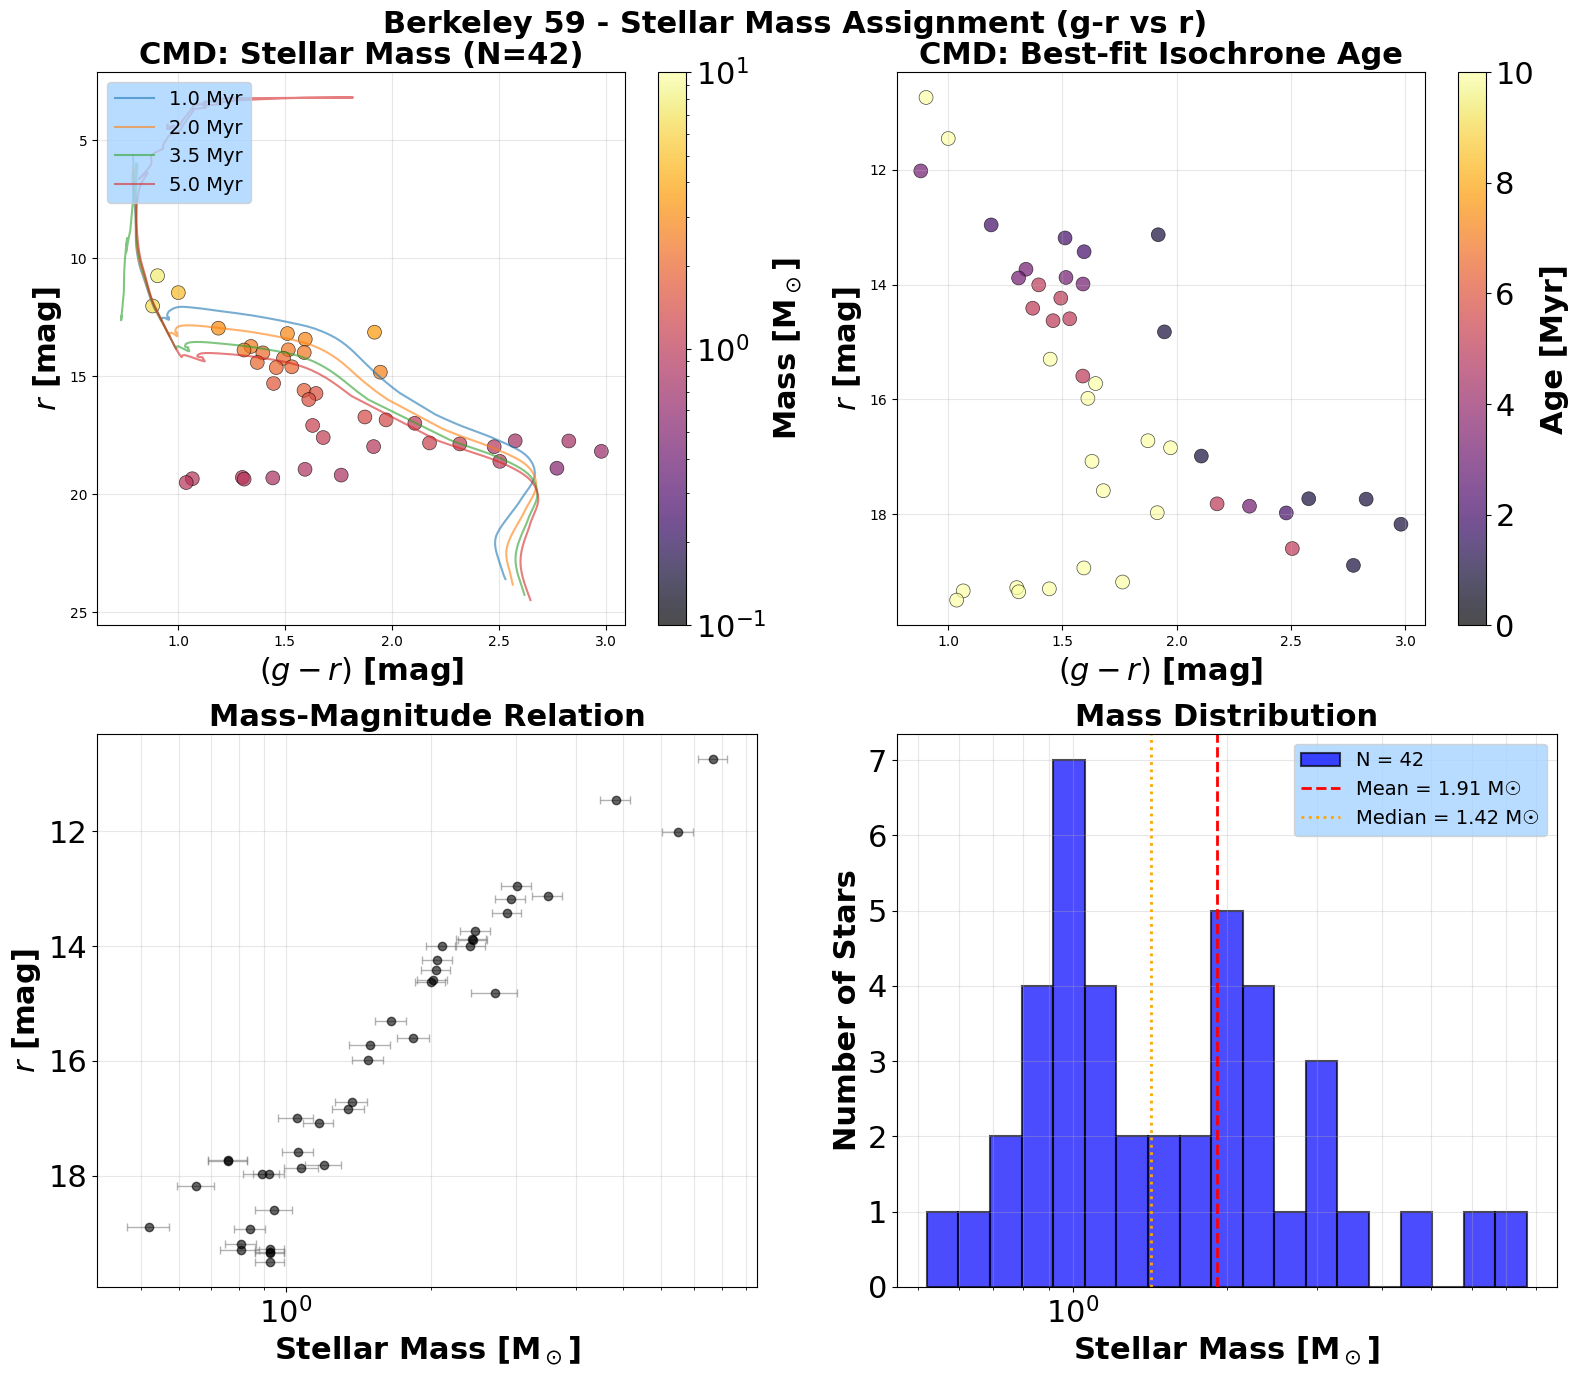

Moderate sample (N=42), using 8 bins
Running 500 bootstrap iterations...
Bootstrap: 500 successful fits
  Median α = 1.91, std = 0.36
Sample size: 42 stars
Mass range: 0.52 - 7.68 M☉
Bins used for fitting: 7 (with ≥2 stars each)
Reduced χ²: 0.61

Power-law index: α = 1.89 ± 0.36
  (dN/dM ∝ M^(-α))

Stellar mass statistics:
  Average mass:  1.912 ± 0.227 M☉
  Median mass:   1.424 M☉

Total cluster mass:
  Observed:                80.3 M☉
  Completeness-corrected:  98.2 M☉



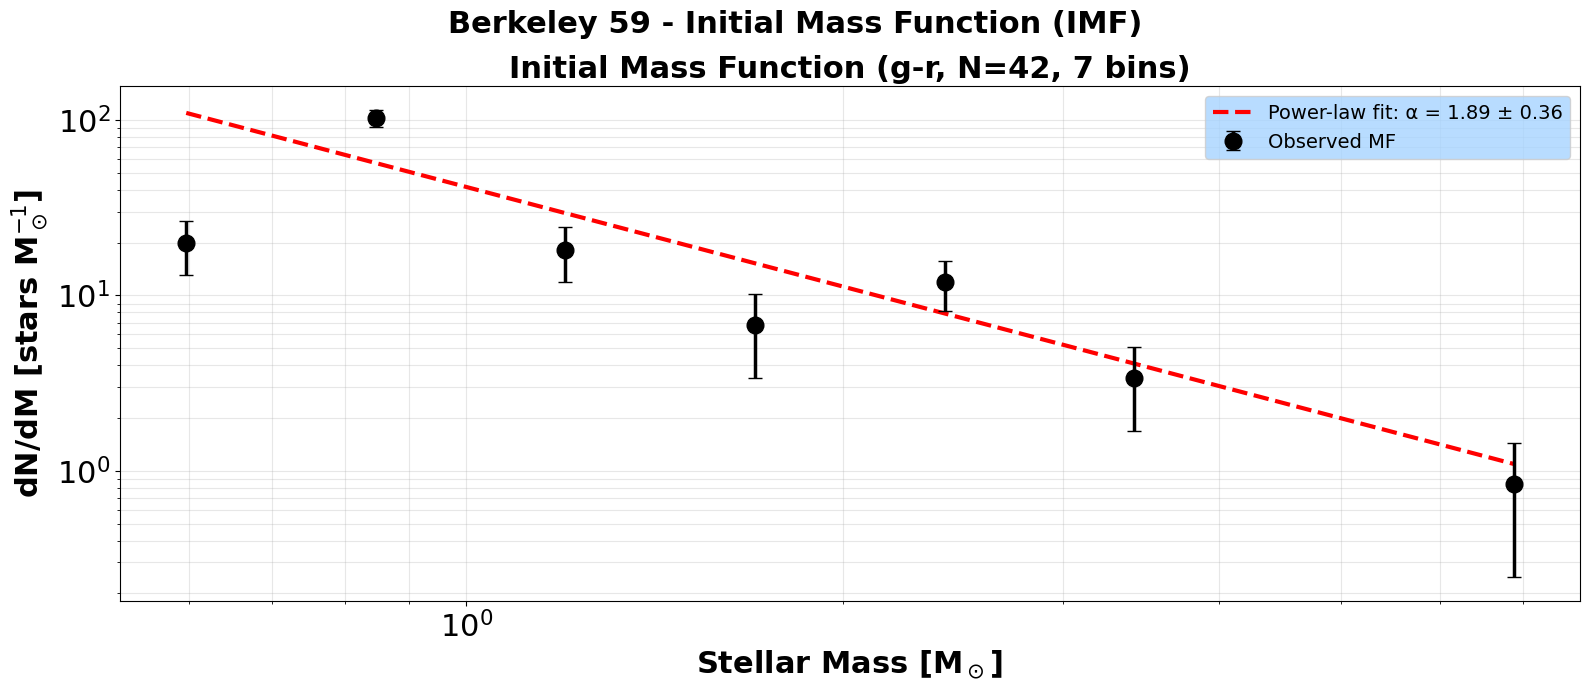

In [ ]:
members_df = in_bounds_df[in_bounds_df['is_member'] & in_bounds_df['valid_phot']].copy()

if len(members_df) == 0:
    print("No cluster members with valid photometry found.")
else:
    available_ages_Myr = np.array([1,2,3.16,5.01,10,15.85,19.95,31.62,50.12,100])
    members_gr = members_df.copy()
    members_gr = assign_masses_from_nearest_isochrone(
        members_gr,
        df,
        available_ages_Myr,
        color_col='color_g_r',
        mag_col='mag_r_cal',
        iso_color_col='g_minus_r_obs',
        iso_mag_col='SDSS_r_obs',
        color_uncertainty=0.05,
        mag_uncertainty=0.05
    )

    members_gr_mass = members_gr[members_gr['mass'].notna()].copy()

    print(f"\nSuccessfully assigned masses to {len(members_gr_mass)}/{len(members_gr)} stars")
    if len(members_gr_mass) > 0:
        print(f"Mass range: {members_gr_mass['mass'].min():.3f} - {members_gr_mass['mass'].max():.2f} M☉")

    if len(members_gr_mass) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 14),)

        # CMD with masses
        ax1 = axes[0, 0]
        scatter = ax1.scatter(
            members_gr_mass['color_g_r'],
            members_gr_mass['mag_r_cal'],
            c=members_gr_mass['mass'],
            cmap='inferno',
            s=100, alpha=0.7,
            edgecolors='black', linewidth=0.5,
            norm=plt.matplotlib.colors.LogNorm(vmin=0.1, vmax=10)
        )

        for age_Myr in [1.0, 2.0, 3.5, 5.0]:
            iso = df[np.abs(df['age_Myr'] - age_Myr) < 0.1]
            if len(iso) > 0:
                ax1.plot(iso['g_minus_r_obs'], iso['SDSS_r_obs'],
                        '-', linewidth=1.5, alpha=0.6, label=f'{age_Myr:.1f} Myr')

        ax1.invert_yaxis()
        ax1.set_xlabel('$(g - r)$ [mag]', fontsize=22, fontweight='bold')
        ax1.set_ylabel('$r$ [mag]', fontsize=22, fontweight='bold')
        ax1.set_title(f'CMD: Stellar Mass (N={len(members_gr_mass)})', fontsize=22, fontweight='bold')
        ax1.legend(fontsize=14, loc='upper left').get_frame().set_facecolor("#A7D4FF")
        ax1.grid(True, alpha=0.3)
        cbar1 = plt.colorbar(scatter, ax=ax1)
        cbar1.set_label('Mass [M$_\\odot$]', fontsize=22, fontweight='bold')
        cbar1.ax.tick_params(labelsize=22)


        # CMD with ages
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(
            members_gr_mass['color_g_r'],
            members_gr_mass['mag_r_cal'],
            c=members_gr_mass['best_age_Myr'],
            cmap='inferno',
            s=100, alpha=0.7,
            edgecolors='black', linewidth=0.5,
            vmin=0, vmax=10
        )
        ax2.invert_yaxis()
        ax2.set_xlabel('$(g - r)$ [mag]', fontsize=22, fontweight='bold')
        ax2.set_ylabel('$r$ [mag]', fontsize=22, fontweight='bold')
        ax2.set_title('CMD: Best-fit Isochrone Age', fontsize=22, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        cbar2 = plt.colorbar(scatter2, ax=ax2)
        cbar2.set_label('Age [Myr]', fontsize=22, fontweight='bold')
        cbar2.ax.tick_params(labelsize=22)


        # Mass-magnitude relation
        ax3 = axes[1, 0]
        ax3.errorbar(
            members_gr_mass['mass'],
            members_gr_mass['mag_r_cal'],
            xerr=members_gr_mass['mass_uncertainty'],
            fmt='o', markersize=6, alpha=0.6,
            capsize=3, elinewidth=1,
            color='black', ecolor='grey'
        )
        ax3.invert_yaxis()
        ax3.set_xlabel('Stellar Mass [M$_\\odot$]', fontsize=22, fontweight='bold')
        ax3.set_ylabel('$r$ [mag]', fontsize=22, fontweight='bold')
        ax3.set_title('Mass-Magnitude Relation', fontsize=22, fontweight='bold')
        ax3.set_xscale('log')
        ax3.grid(True, alpha=0.3, which='both')
        ax3.tick_params(labelsize=22)


        # Mass histogram
        ax4 = axes[1, 1]
        bins_hist = np.logspace(
            np.log10(max(members_gr_mass['mass'].min(), 0.1)),
            np.log10(members_gr_mass['mass'].max()),
            20
        )
        ax4.hist(members_gr_mass['mass'], bins=bins_hist, alpha=0.7,
                label=f'N = {len(members_gr_mass)}',
                color='blue', edgecolor='black', linewidth=1.5)
        ax4.axvline(np.mean(members_gr_mass['mass']), color='red',
                   linestyle='--', linewidth=2, label=f'Mean = {np.mean(members_gr_mass["mass"]):.2f} M☉')
        ax4.axvline(np.median(members_gr_mass['mass']), color='orange',
                   linestyle=':', linewidth=2, label=f'Median = {np.median(members_gr_mass["mass"]):.2f} M☉')
        ax4.set_xlabel('Stellar Mass [M$_\\odot$]', fontsize=22, fontweight='bold')
        ax4.set_ylabel('Number of Stars', fontsize=22, fontweight='bold')
        ax4.set_title('Mass Distribution', fontsize=22, fontweight='bold')
        ax4.set_xscale('log')
        ax4.legend(fontsize=14).get_frame().set_facecolor("#A7D4FF")
        ax4.grid(True, alpha=0.3, which='both')
        ax4.tick_params(labelsize=22)


        plt.suptitle('Berkeley 59 - Stellar Mass Assignment (g-r vs r)',
                     fontsize=22, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Mass function analysis for g-r
        mf_results_gr = compute_mass_function_with_errors(
            members_gr_mass,
            completeness_limit_mag=17.5,
            min_mass=0.1,
            max_mass=10
        )

        if mf_results_gr is not None:
            fig, axes = plt.subplots(1, 1, figsize=(16, 7),)

            # Differential MF
            # Corrected: Use the single axes object directly
            ax1 = axes
            valid = mf_results_gr['valid_mask']

            ax1.errorbar(
                mf_results_gr['bin_centers'][valid],
                mf_results_gr['mass_function'][valid],
                yerr=mf_results_gr['mf_uncertainty'][valid],
                fmt='o', markersize=12, capsize=5,
                linewidth=2.5, color='black',
                label='Observed MF', zorder=3
            )

            mass_range = np.logspace(
                np.log10(mf_results_gr['fit_masses'].min()),
                np.log10(mf_results_gr['fit_masses'].max()),
                200
            )
            fit_line = power_law(mass_range, mf_results_gr['alpha'], mf_results_gr['A'])

            ax1.plot(mass_range, fit_line, 'r--', linewidth=3,
                    label=f'Power-law fit: α = {mf_results_gr["alpha"]:.2f} ± {mf_results_gr["alpha_uncertainty"]:.2f}',
                    zorder=2)

            ax1.set_xlabel('Stellar Mass [M$_\\odot$]', fontsize=22, fontweight='bold')
            ax1.set_ylabel('dN/dM [stars M$_\\odot^{-1}$]', fontsize=22, fontweight='bold')
            ax1.set_title(f'Initial Mass Function (g-r, N={mf_results_gr["n_stars"]}, {mf_results_gr["n_bins_fit"]} bins)',
                         fontsize=22, fontweight='bold')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.legend(fontsize=14, loc='best').get_frame().set_facecolor("#A7D4FF")
            ax1.grid(True, alpha=0.3, which='both')
            ax1.tick_params(labelsize=22)


            plt.suptitle(f'Berkeley 59 - Initial Mass Function (IMF)',
                        fontsize=22, fontweight='bold')
            plt.tight_layout()
            plt.show()

Distance Checker

In [ ]:
print(members_df.columns)

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ruwe', 'phot_g_mean_flux_over_error',
       'phot_bp_mean_flux_over_error', 'phot_rp_mean_flux_over_error',
       'astrometric_excess_noise', 'visibility_periods_used', 'is_member',
       'x_pix_g', 'y_pix_g', 'x_pix_r', 'y_pix_r', 'x_pix_i', 'y_pix_i',
       'in_bounds', 'flux_g', 'flux_r', 'flux_i', 'bkg_g', 'bkg_r', 'bkg_i',
       'valid_phot', 'mag_g_inst', 'mag_r_inst', 'mag_i_inst', 'mag_g_cal',
       'mag_r_cal', 'mag_i_cal', 'color_g_r', 'color_r_i', 'color_g_i'],
      dtype='object')


In [ ]:
from astroquery.mast import Catalogs
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from sklearn.linear_model import LinearRegression

# Your instrumental data frame: members_df with columns 'ra', 'dec', 'mag_g_cal', 'mag_r_cal', 'mag_i_cal', 'color_g_r', 'color_r_i'

def query_panstarrs(ra, dec, radius_arcsec=2):
    """
    Query Pan-STARRS catalog for sources around (ra, dec) within radius_arcsec.
    Returns a pandas DataFrame of Pan-STARRS sources.
    """
    radius_deg = radius_arcsec / 3600.0
    result = Catalogs.query_region(f"{ra} {dec}", radius=radius_deg * u.deg, catalog="Panstarrs", data_release="dr2")
    return result.to_pandas()

# Collect Pan-STARRS magnitudes for all your stars
ps_mags = []
for idx, row in members_df.iterrows():
    ra = row['ra']
    dec = row['dec']
    panstarrs_data = query_panstarrs(ra, dec, radius_arcsec=2)

    if len(panstarrs_data) == 0:
        ps_mags.append({'gmag': np.nan, 'rmag': np.nan, 'imag': np.nan})
        continue

    # Find closest Pan-STARRS source
    pan_coords = SkyCoord(panstarrs_data['raMean'], panstarrs_data['decMean'], unit='deg')
    star_coord = SkyCoord(ra, dec, unit='deg')
    idx_closest, sep, _ = star_coord.match_to_catalog_sky(pan_coords)
    if sep.arcsecond > 2:
        ps_mags.append({'gmag': np.nan, 'rmag': np.nan, 'imag': np.nan})
    else:
        closest_source = panstarrs_data.iloc[idx_closest]
        ps_mags.append({
            'gmag': closest_source['gMeanPSFMag'],
            'rmag': closest_source['rMeanPSFMag'],
            'imag': closest_source['iMeanPSFMag']
        })

# Add Pan-STARRS magnitudes to your dataframe
panstarrs_df = pd.DataFrame(ps_mags, index=members_df.index)
members_df = pd.concat([members_df, panstarrs_df], axis=1)

# Filter out rows without Pan-STARRS data for calibration
mask = members_df[['gmag', 'rmag', 'imag']].notnull().all(axis=1)
calib_df = members_df[mask]

# Prepare instrumental mags and colors for calibration
Xg = calib_df['mag_g_cal'].values.reshape(-1, 1)
Xr = calib_df['mag_r_cal'].values.reshape(-1, 1)
Xi = calib_df['mag_i_cal'].values.reshape(-1, 1)

color_gr = (calib_df['mag_g_cal'] - calib_df['mag_r_cal']).values.reshape(-1, 1)
color_ri = (calib_df['mag_r_cal'] - calib_df['mag_i_cal']).values.reshape(-1, 1)

y_g = calib_df['gmag'].values
y_r = calib_df['rmag'].values
y_i = calib_df['imag'].values

def fit_calibration(inst_mag, color, std_mag):
    A = np.hstack([inst_mag, color, np.ones_like(inst_mag)])
    model = LinearRegression(fit_intercept=False)
    model.fit(A, std_mag)
    return model.coef_.flatten()  # or model.coef_[0]


coef_g = fit_calibration(Xg, color_gr, y_g)
coef_r = fit_calibration(Xr, color_ri, y_r)
coef_i = fit_calibration(Xi, color_ri, y_i)

print("Calibration coefficients (g): a*g + b*(g-r) + c =", coef_g)
print("Calibration coefficients (r): a*r + b*(r-i) + c =", coef_r)
print("Calibration coefficients (i): a*i + b*(r-i) + c =", coef_i)

def apply_calibration(inst_mag, color, coef):
    return coef[0]*inst_mag + coef[1]*color + coef[2]

members_df['g_calibrated'] = apply_calibration(members_df['mag_g_cal'], members_df['color_g_r'], coef_g)
members_df['r_calibrated'] = apply_calibration(members_df['mag_r_cal'], members_df['color_r_i'], coef_r)
members_df['i_calibrated'] = apply_calibration(members_df['mag_i_cal'], members_df['color_r_i'], coef_i)

print(members_df[['g_calibrated', 'r_calibrated', 'i_calibrated']].head())

Calibration coefficients (g): a*g + b*(g-r) + c = [ 1.25278876 -0.92630438 -3.18932854]
Calibration coefficients (r): a*r + b*(r-i) + c = [ 1.24299853 -1.2480092  -2.4516435 ]
Calibration coefficients (i): a*i + b*(r-i) + c = [ 1.13808782 -0.50983599 -1.2403064 ]
    g_calibrated  r_calibrated  i_calibrated
1      10.555631      9.541303      9.193179
3      11.483840     10.574019     10.196698
16     13.822634     12.647146     12.061670
21     14.150731     12.902776     12.278354
28     14.450456     13.510131     12.926615


In [ ]:
print(members_df[['g_calibrated', 'r_calibrated', 'i_calibrated']])

     g_calibrated  r_calibrated  i_calibrated
1       10.555631      9.541303      9.193179
3       11.483840     10.574019     10.196698
16      13.822634     12.647146     12.061670
21      14.150731     12.902776     12.278354
28      14.450456     13.510131     12.926615
30      14.687085     13.507281     12.850720
31      14.854598     13.569636     12.875552
32      14.630658     13.714745     13.120161
38      14.809500     13.791069     13.160648
41      15.130698     13.944096     13.246363
46      15.311320     14.275548     13.595372
47      16.015764     14.191141     13.276474
49      15.594446     14.378334     13.638565
50      15.612720     14.495658     13.776610
62      16.448639     15.222783     14.399326
71      12.152524     11.481104     11.110101
72      16.864474     15.478389     14.588501
83      17.045757     15.673619     14.780796
101     18.370279     16.457889     15.314355
110     18.556248     16.650822     15.507409
114     18.781133     16.795185   

In [ ]:
# Define image center and size as before
center_ra = 0.57        # degrees
center_dec = 67.441     # degrees

image_width_arcsec = 653  # precisely 652.7
image_height_arcsec = 449 # precisely 448.1

width_deg = image_width_arcsec / 3600.0
height_deg = image_height_arcsec / 3600.0

ra_min = center_ra - width_deg / 2.0 / np.cos(np.deg2rad(center_dec))
ra_max = center_ra + width_deg / 2.0 / np.cos(np.deg2rad(center_dec))
dec_min = center_dec - height_deg / 2.0
dec_max = center_dec + height_deg / 2.0

# Query Gaia sources in bounding box
query = f"""
SELECT source_id, ra, dec, parallax, parallax_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE ra BETWEEN {ra_min} AND {ra_max}
AND dec BETWEEN {dec_min} AND {dec_max}
"""
job = Gaia.launch_job(query)
gaia_table = job.get_results()

# Create SkyCoord objects for your catalog and Gaia sources
stars_coords = SkyCoord(ra=members_df['ra'], dec=members_df['dec'], unit='deg')
gaia_coords = SkyCoord(ra=gaia_table['ra'], dec=gaia_table['dec'], unit='deg')

# Set a maximum matching separation
max_sep = 2.4 * u.arcsec

# Find all Gaia sources within max_sep of each star (many-to-many)
idx_star, idx_gaia, d2d, _ = gaia_coords.search_around_sky(stars_coords, max_sep)

# Count how many matches each star got (indices come from idx_star, which reference positions in stars_coords)
match_counts = pd.Series(idx_star).value_counts()

# Select stars with exactly one Gaia match
single_match_star_indices = match_counts[match_counts == 1].index

# Filter your stars DataFrame to keep only these stars
stars_single_match = members_df.iloc[single_match_star_indices]

# Optionally, get corresponding Gaia matches for these stars
# to do this, filter idx_star to these indices:
mask = pd.Series(idx_star).isin(single_match_star_indices)
idx_star_single = np.array(idx_star)[mask]
idx_gaia_single = np.array(idx_gaia)[mask]

In [ ]:
print(len(idx_star_single), idx_star_single)

36 [ 1  2  3  4  6  7  9 10 11 12 13 14 16 17 18 19 20 22 23 24 25 26 28 29
 30 31 32 33 34 35 36 37 38 39 40 41]


In [ ]:
# Get matched stars rows
stars_matched = members_df.iloc[idx_star_single].reset_index(drop=True)

# Get matched Gaia data rows
gaia_matched = gaia_table[idx_gaia_single].to_pandas().reset_index(drop=True)

# Calculate distance from parallax in parsecs, handle zero or negative parallaxes safely
# Distance (pc) = 1000 / parallax (mas)
gaia_matched['distance_pc'] = gaia_matched['parallax'].apply(
    lambda p: 1000.0 / p if p > 0 else np.nan
)


# Build the DataFrame with simplified column names
stars_df_matched = pd.DataFrame({
    'source_id': stars_matched['source_id'] if 'source_id' in stars_matched.columns else stars_matched.index,
    'ra': stars_matched['ra'],
    'dec': stars_matched['dec'],
    'parallax': gaia_matched['parallax'],
    'parallax_error': gaia_matched['parallax_error'],
    'distance_pc': gaia_matched['distance_pc'],
})

# Now stars_df_dist_corrected contains original stars plus Gaia info with distances

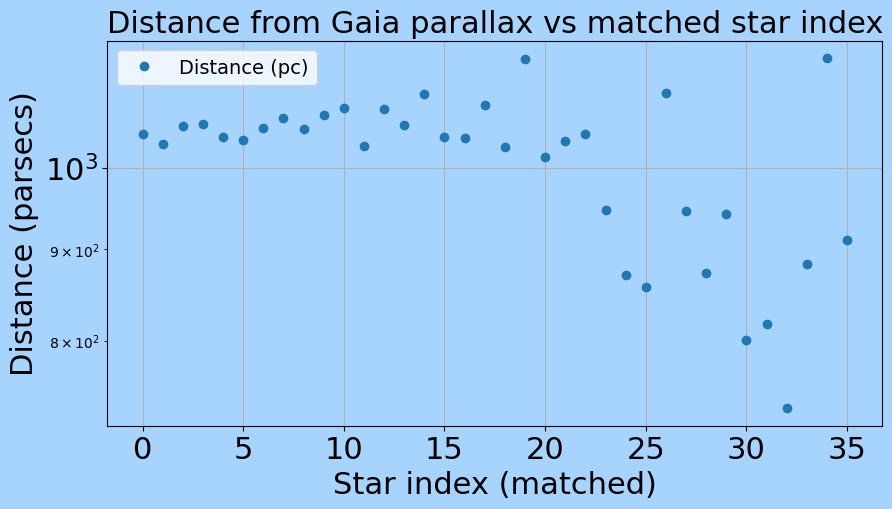

In [ ]:
# Plotting distances

indices = np.arange(len(stars_df_matched))
distances = stars_df_matched['distance_pc'].values

fig, ax = plt.subplots(figsize=(10, 5),)
ax.plot(indices, distances, marker='o', linestyle='none', label='Distance (pc)')
ax.set_xlabel('Star index (matched)', fontsize=22)
ax.set_ylabel('Distance (parsecs)', fontsize=22)
ax.set_title('Distance from Gaia parallax vs matched star index', fontsize=22)
ax.set_yscale('log')  # Optional: log scale for better dynamic range visualization
ax.grid(True)
# ax.set_ylim(750,1250)
ax.legend(fontsize=14)
fig.patch.set_facecolor('#A7D4FF')
ax.set_facecolor('#A7D4FF')
ax.tick_params(labelsize=22)
plt.show()

In [ ]:
print(np.mean(stars_df_matched['distance_pc']))

1003.0182354597512


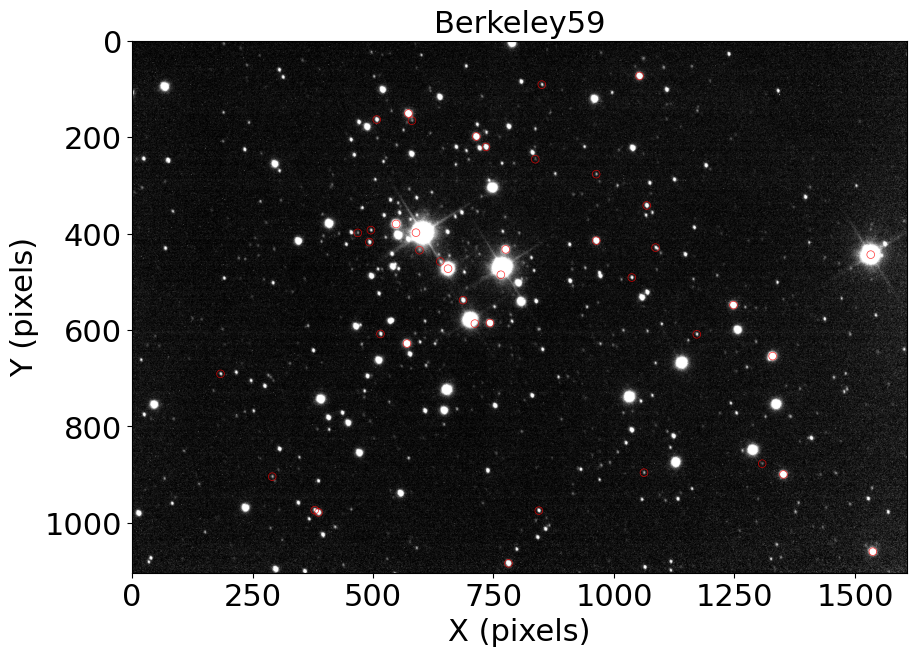

In [ ]:
# Update coordinate arrays accordingly
cluster_ra_array = members_df['ra'].to_numpy()
cluster_dec_array = members_df['dec'].to_numpy()
cluster_ID_array = members_df['source_id'].to_numpy()

# Create coordinate array for WCS conversion
coords = np.column_stack([cluster_ra_array, cluster_dec_array])

# Convert to pixel coordinates using WCS
x_pix_r, y_pix_r = wcs_r.wcs_world2pix(coords, 0).T
x_pix_g, y_pix_g = wcs_g.wcs_world2pix(coords, 0).T
x_pix_i, y_pix_i = wcs_i.wcs_world2pix(coords, 0).T

# Plot observational stars
interval = AsymmetricPercentileInterval(30, 99)  # ignore extreme 1% low and 1% high pixels
vmin, vmax = interval.get_limits(image_i)
# norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())
fig, ax = plt.subplots(figsize=(10, 10),)
ax.imshow(image_i, vmin=vmin, vmax=vmax, cmap='gray')

# Plot catalouge stars
for x, y in zip(x_pix_i, y_pix_i):
    circle = plt.Circle((x, y), radius=8, edgecolor='red', alpha=0.8, facecolor='none', linewidth=0.5)
    ax.add_artist(circle)

ax.set_title(f'Berkeley59', fontsize=22)
ax.set_xlabel('X (pixels)', fontsize=22)
ax.set_ylabel('Y (pixels)', fontsize=22)
ax.set_facecolor('#A7D4FF')
ax.tick_params(labelsize=22)
plt.show()